In [3]:
#importing important libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from skmultilearn.model_selection import iterative_train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss,f1_score,confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

from sklearn.preprocessing import LabelEncoder
import optuna

In [4]:
import random
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(seed=42)

In [5]:
#reading train dataset

train_features=pd.read_csv('data/train_features.csv')
test_features=pd.read_csv('data/test_features.csv')
train_targets_scored=pd.read_csv('data/train_targets_scored.csv')
train_targets_nonscored=pd.read_csv('data/train_targets_nonscored.csv')
train_drug=pd.read_csv('data/train_drug.csv')

In [6]:
#list of names of the MoAs in the dataset
target_cols_scored=[col for col in train_targets_scored.columns if col not in ['sig_id']]
target_cols_nonscored=[col for col in train_targets_nonscored.columns if col not in ['sig_id']]

In [7]:
#separating gene feautres and cell features in a separate list
#we know that all the gene expression features name starts with 'g-' and cell features name starts with 'c-', hence trying to observe set of all the gene expression as one function and all the cell functions as one features
gene_features=[]
cell_features=[]
for i in train_features.columns:
    if i.startswith('g-'):
        gene_features.append(i)
    if i.startswith('c-'):
        cell_features.append(i)

In [8]:
#merging the train dataset and train target scored dataset into one
train_merge=pd.merge(train_features,train_targets_scored,on="sig_id",how="left")

In [9]:
train_merge=train_merge[train_merge['cp_type']!='ctl_vehicle']
#test_features1=test_features.copy()
test_features1=test_features[test_features['cp_type']!='ctl_vehicle']

In [10]:
train_merge.drop(columns=['cp_type'],inplace=True)
test_features1.drop(columns=['cp_type'],inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import *

In [12]:
from sklearn.decomposition import PCA



def PCA_decomposition(train,valid,test,n_comp_gene,n_comp_cell):
    
    '''
    function is used to generate pca components of gene and cell features of train, validationa and test set
    Args:
        train:train dataset
        valid:validation dataset
        test:test dataset
        n_comp_gene: number of PCA components for gene features
        n_comp_cell: number of PCA components for cell features
        
    Returns:
    
        train:train dataset with concatenation of pca generated features
        valid:validation dataset with concatenation of pca generated features
        test:test dataset with concatenation of pca generated features
        
    '''
    
    pca_gene_feat=[f'pca_gene_{col}' for col in range(n_comp_gene)]
    pca_cell_feat=[f'pca_cell_{col}' for col in range(n_comp_cell)]
    pca_gene=PCA(n_components=n_comp_gene,random_state=42)
    X_train_pca_gene=pd.DataFrame(pca_gene.fit_transform(train[gene_features]),columns=pca_gene_feat).reset_index(drop=True)
    X_valid_pca_gene=pd.DataFrame(pca_gene.transform(valid[gene_features]), columns=pca_gene_feat).reset_index(drop=True)
    X_test_pca_gene=pd.DataFrame(pca_gene.transform(test[gene_features]), columns=pca_gene_feat).reset_index(drop=True)

    pca_cell=PCA(n_components=n_comp_cell,random_state=42)
    X_train_pca_cell=pd.DataFrame(pca_cell.fit_transform(train[cell_features]), columns=pca_cell_feat).reset_index(drop=True)
    X_valid_pca_cell=pd.DataFrame(pca_cell.transform(valid[cell_features]), columns=pca_cell_feat).reset_index(drop=True)
    X_test_pca_cell=pd.DataFrame(pca_cell.transform(test[cell_features]), columns=pca_cell_feat).reset_index(drop=True)
    
    train=pd.concat([train.reset_index(drop=True),X_train_pca_gene,X_train_pca_cell],axis=1)
    valid=pd.concat([valid.reset_index(drop=True),X_valid_pca_gene,X_valid_pca_cell],axis=1)
    test=pd.concat([test.reset_index(drop=True),X_test_pca_gene,X_test_pca_cell],axis=1)
    return train,valid,test
    


In [13]:
from sklearn.preprocessing import QuantileTransformer
def quantile_scaling(train,valid,test):
    
       '''
       takes in input, valid, test for quantile transformation
       Args:
            train:train dataset
            valid:validation dataset
            test:test dataset
       Returns:
            train: transformed train dataset
            valid: transformed validation dataset
            test:  transformed test dataset
        
        '''
    
       qt=QuantileTransformer(output_distribution='normal')
       train=qt.fit_transform(train)
       valid=qt.transform(valid)
       test=qt.transform(test)
       return train,valid,test

In [14]:
#Label encoding of 'cp_time' and 'cp_dose' features

lb=LabelEncoder()
lb.fit(train_merge['cp_time'])

train_merge['cp_time']=lb.transform(train_merge['cp_time'])
test_features1['cp_time']=lb.transform(test_features1['cp_time'])
##################################################################################
lb1=LabelEncoder()
lb1.fit(train_merge['cp_dose'])

train_merge['cp_dose']=lb1.transform(train_merge['cp_dose'])
test_features1['cp_dose']=lb1.transform(test_features1['cp_dose'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [15]:
#feature groups that would be used in training
feature_groups=gene_features+cell_features+['cp_time','cp_dose']

In [16]:
train_dataset=train_merge[feature_groups]

In [17]:
test_dataset=test_features1[feature_groups]

In [18]:
Y=train_merge[target_cols_scored]


In [19]:
#define frequency table
def f_table(list1):
    table_dic={}
    for i in list1:
        if i not in table_dic.keys():
            table_dic[i]=1
        else:
            table_dic[i]+=1
    return table_dic

In [20]:
from copy import deepcopy as dp


In [21]:
tar_freq = np.array([np.min(list(f_table(train_merge[target_cols_scored].iloc[:,i]).values())) for i in range(len(target_cols_scored))])
tar_weight0 = np.array([np.log(i+100) for i in tar_freq])
tar_weight0_min = dp(np.min(tar_weight0))
tar_weight = tar_weight0_min/tar_weight0

In [22]:
def logloss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred,0.001,0.999)
    return -backend.mean(y_true*backend.log(y_pred) + (1-y_true)*backend.log(1-y_pred))

In [23]:
import tensorflow_addons as tfa


In [24]:
def simple_model(feature_len):
     
     inp=Input(shape=(feature_len,))
        
     bn = BatchNormalization()(inp)
    
     dense1 =tfa.layers.WeightNormalization(Dense(418,activation='elu'))(bn)
     bn=BatchNormalization()(dense1) 
     drop1=Dropout( 0.547371471990173)(bn)
        
     dense2=tfa.layers.WeightNormalization(Dense(1056,activation='selu'))(drop1)
     bn=BatchNormalization()(dense2) 
     drop1=Dropout(0.07185519891550776)(bn)
     

     dense3=tfa.layers.WeightNormalization(Dense(1027,activation='selu'))(drop1)
     bn=BatchNormalization()(dense3) 
     drop1=Dropout(0.1948409329101518)(bn)
        
     
     dense4=tfa.layers.WeightNormalization(Dense(1418,activation='selu'))(drop1)
     bn=BatchNormalization()(dense4) 
     drop1=Dropout(0.279332285021747)(bn)
     
    
     bn=BatchNormalization()(drop1) 
     drop2=Dropout(0.10731970101147598)(bn)
     output=tfa.layers.WeightNormalization(Dense(206,activation='sigmoid'))(drop2)
     model=tf.keras.Model(inputs=inp,outputs=output)
    
     return model

In [25]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min', min_lr=1e-5)
early_stopping =tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1E-5, patience=7, mode='min',restore_best_weights=True)

In [26]:
from tensorflow.keras import backend

In [27]:
import warnings
warnings.filterwarnings("ignore")



2021-10-29 13:56:09.739493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 13:56:09.836541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 13:56:09.837611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 13:56:09.839504: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

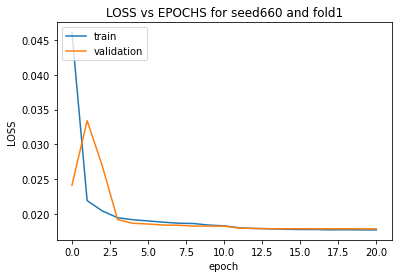

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 1


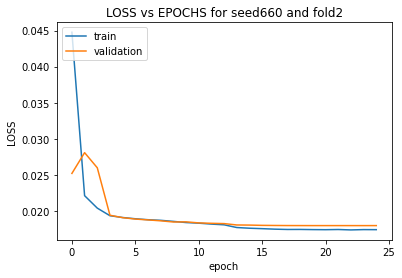

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 2


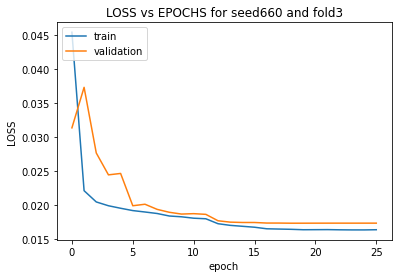

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 3


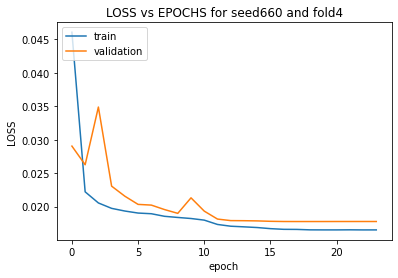

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 4


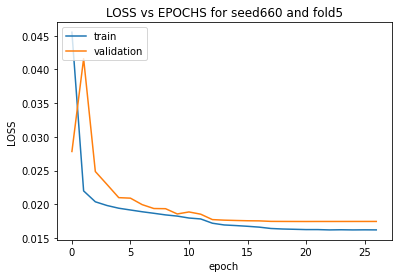

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 5


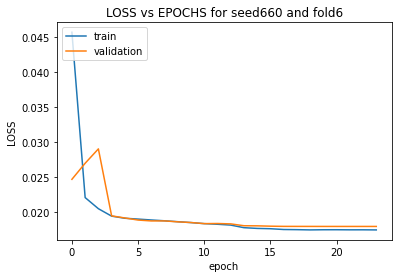

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 6


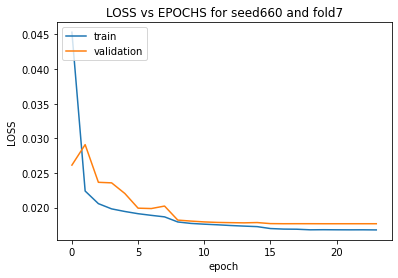

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 7


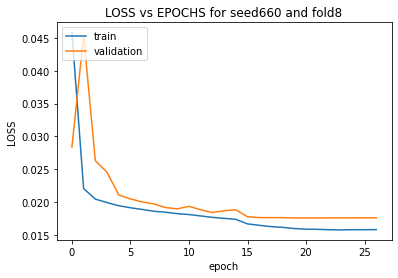

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 8


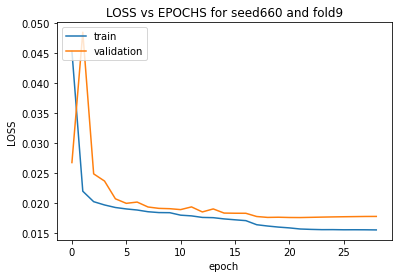

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 9


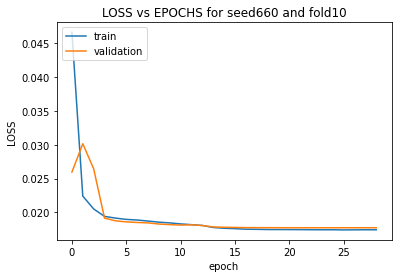

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 10
&&&&&&&&&&&&&&&&&&&&&&&&&&&END of SEED660


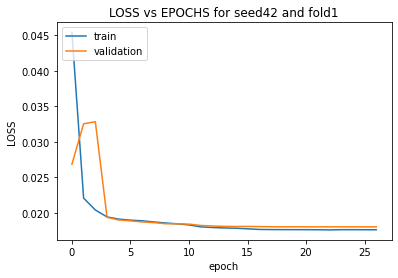

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 1


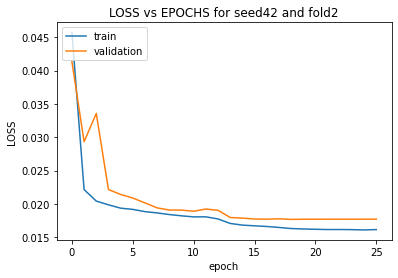

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 2


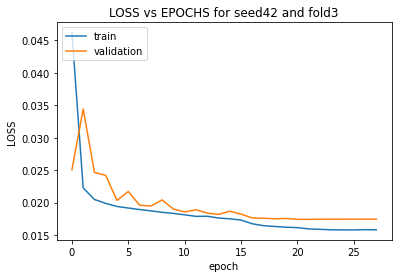

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 3


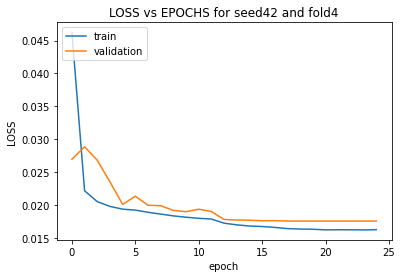

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 4


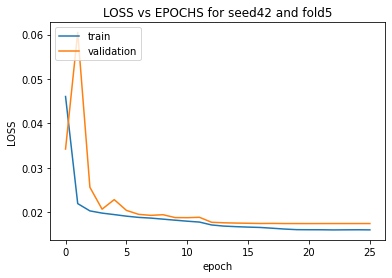

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 5


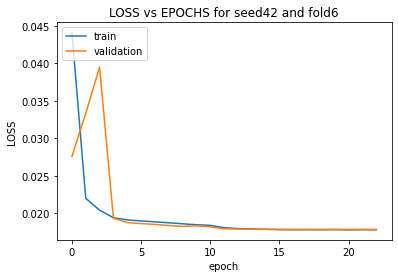

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 6


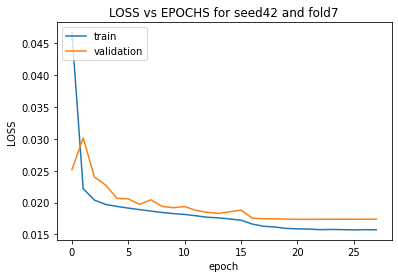

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 7


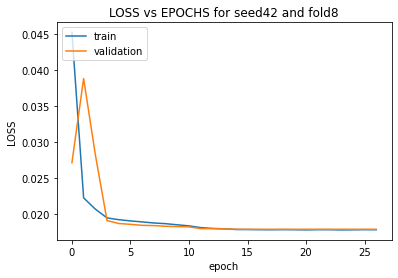

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 8


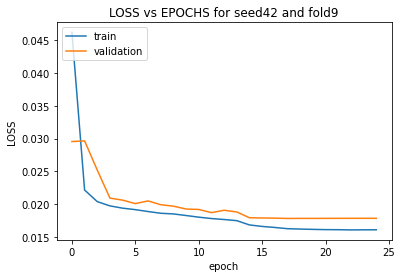

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 9


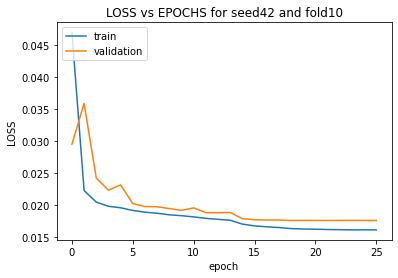

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 10
&&&&&&&&&&&&&&&&&&&&&&&&&&&END of SEED42


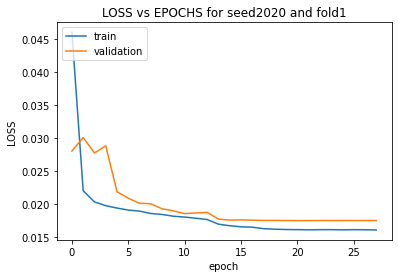

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 1


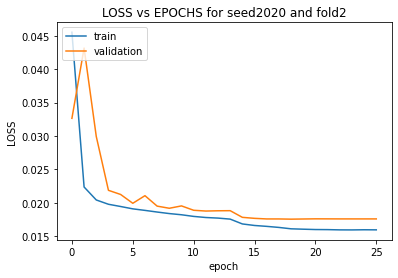

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 2


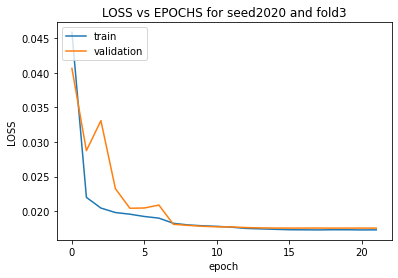

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 3


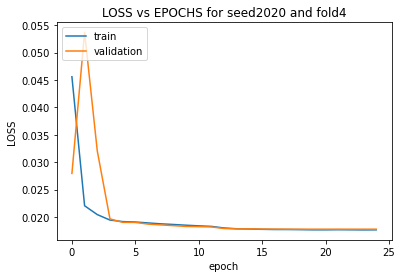

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 4


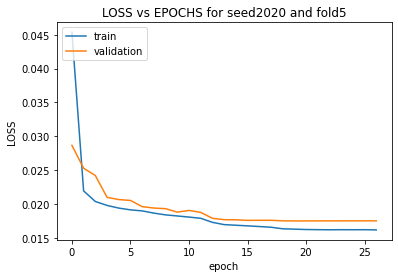

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 5


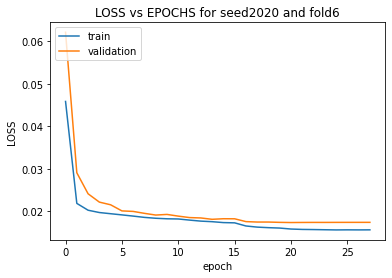

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 6


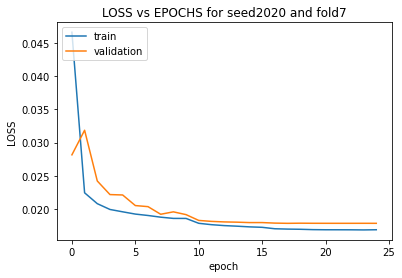

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 7


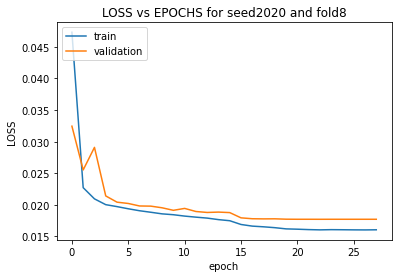

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 8


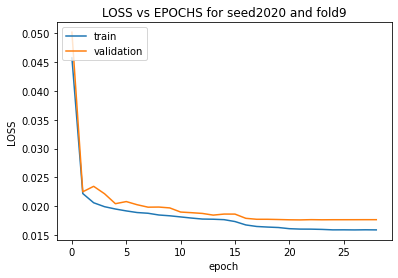

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 9


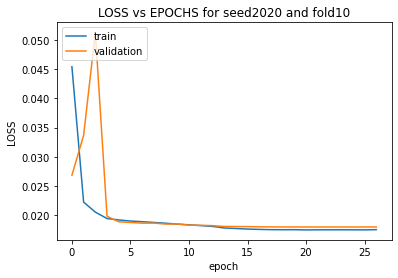

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 10
&&&&&&&&&&&&&&&&&&&&&&&&&&&END of SEED2020


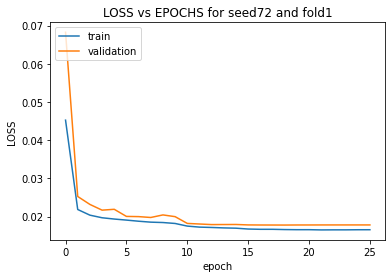

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 1


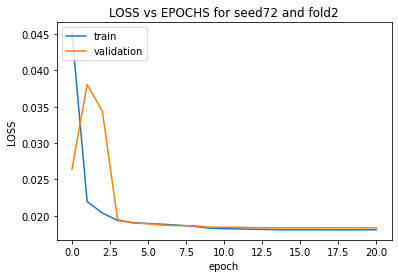

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 2


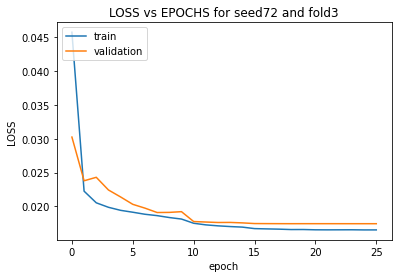

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 3


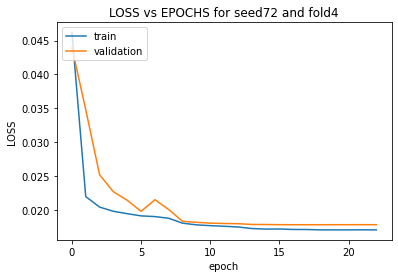

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 4


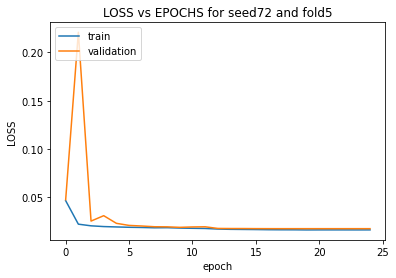

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 5


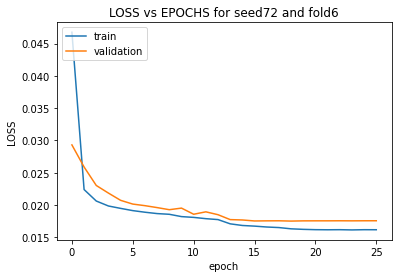

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 6


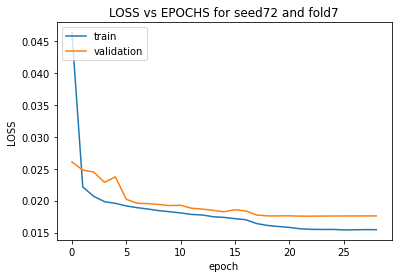

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 7


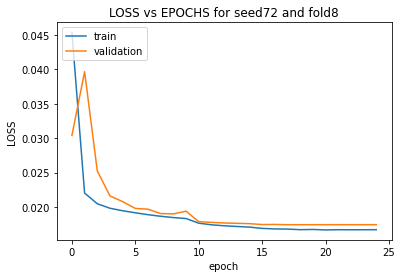

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 8


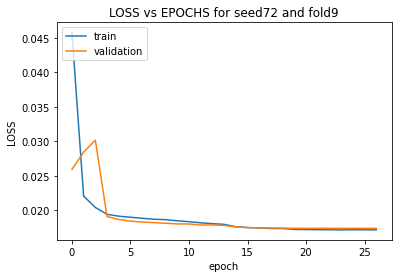

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 9


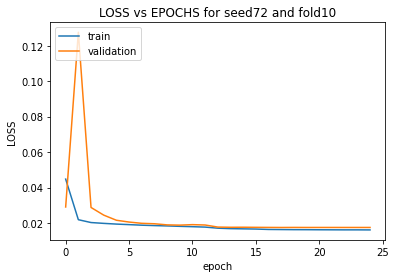

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 10
&&&&&&&&&&&&&&&&&&&&&&&&&&&END of SEED72


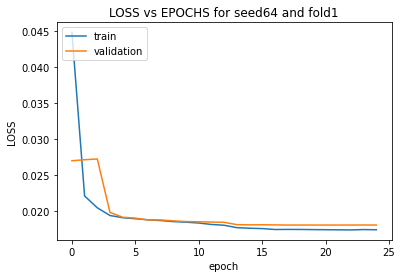

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 1


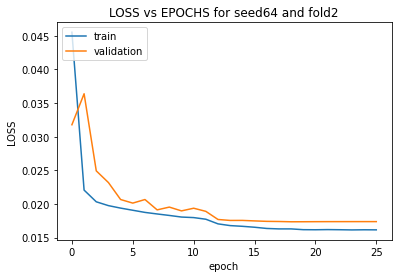

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 2


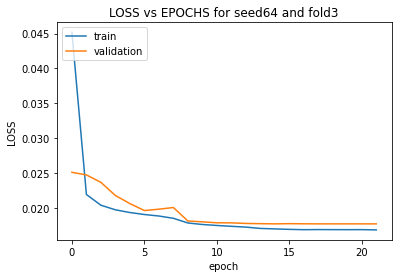

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 3


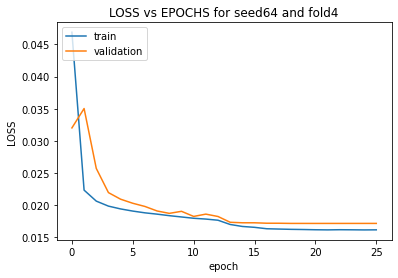

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 4


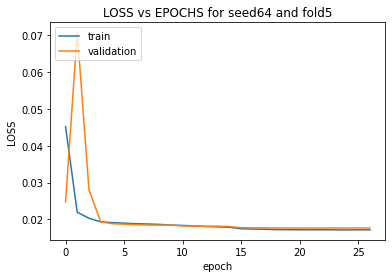

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 5


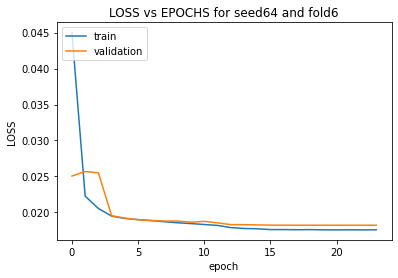

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 6


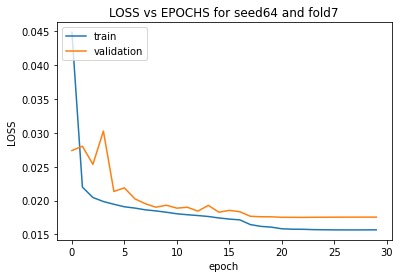

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 7


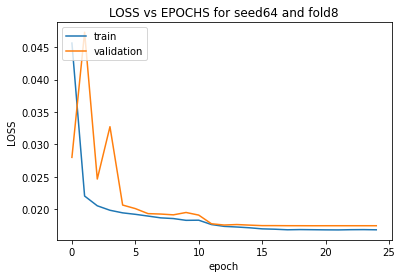

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 8


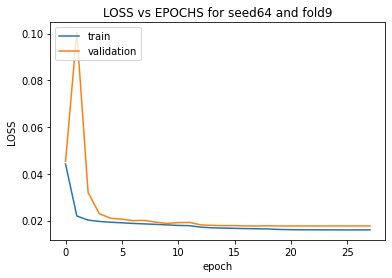

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 9


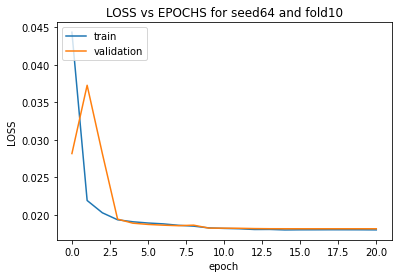

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold 10
&&&&&&&&&&&&&&&&&&&&&&&&&&&END of SEED64


In [28]:
n_folds=10
tf.keras.backend.clear_session()

y_pred_seed_level=np.zeros((len(test_dataset),206),dtype='float32')
oof1_seed_level=np.zeros((len(train_dataset),206),dtype='float32')
SEEDS=[660,42,2020,72,64]
#Training is done across 5 different seeds and 10 differents folds to address the diversity in the dataset
for seed in SEEDS:
    seed_everything(seed)
    fold=0
    mskf = MultilabelStratifiedKFold(n_splits=n_folds,shuffle=True,random_state=seed)
    y_pred_fold_level=np.zeros((len(test_dataset),206))
    oof1_fold_level=np.zeros((len(train_dataset),206))
    for train_idx, test_idx in mskf.split(train_dataset,Y):
            train=train_dataset.iloc[train_idx]
            validation=train_dataset.iloc[test_idx]

            label_train=Y[target_cols_scored].iloc[train_idx]
            label_validation=Y[target_cols_scored].iloc[test_idx]

            test1=test_dataset.copy()

            train,validation,test1=PCA_decomposition(train,validation,test1,212,42)

            train,validation,test1=quantile_scaling(train,validation,test1)

            model2=simple_model(train.shape[1])
            model2.compile(optimizer=tf.keras.optimizers.Adam(0.23166437075654014,decay=9.357132197174088e-05),loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.001),loss_weights=tar_weight)
            history2=model2.fit(train,label_train,batch_size=256,epochs=150,validation_data=(validation,label_validation),callbacks=[reduce_lr,early_stopping],verbose=0)

            #print("##############################################end of MODEL-2####################################################################")
            model2.save(f'model1_simple_nn_blending_seed{seed}_fold{fold}.h5')

            y_pred2=model2.predict(test1)
            y_valid2=model2.predict(validation)
            y_pred_fold_level=y_pred_fold_level+y_pred2
            oof1_fold_level[test_idx]=y_valid2
            fold=fold+1
            %matplotlib inline
            #print history loss validation and training
            plt.plot(history2.history['loss'])
            plt.plot(history2.history['val_loss'])
            plt.ylabel('LOSS')
            plt.xlabel('epoch')
            plt.title(f'LOSS vs EPOCHS for seed{seed} and fold{fold}')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.plot()
            plt.pause(0.0001)
            print(f'^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^End_of_Fold {fold}')
    print(f'&&&&&&&&&&&&&&&&&&&&&&&&&&&END of SEED{seed}')
    y_pred_seed_level=y_pred_seed_level+y_pred_fold_level
    oof1_seed_level=oof1_seed_level+oof1_fold_level
    
    

<h2> OBSERVATION </h2>

One thing we can clearly observe from the plots that there is no case of overfitting.

In [29]:
y_pred_seed_level=y_pred_seed_level/(n_folds*len(SEEDS))


In [30]:
oof2_seed_level=oof1_seed_level/len(SEEDS)

In [31]:
def logloss1(y_true, y_pred):
    return -backend.mean(y_true*backend.log(y_pred) + (1-y_true)*backend.log(1-y_pred))

In [32]:
logloss1(train_merge[target_cols_scored].values,oof2_seed_level)

<tf.Tensor: shape=(), dtype=float64, numpy=0.015574050605272291>

<h2> OBSERVATION </h2> 

The averaged log loss value for the out of fold data across all the seeds is 0.0155740.

In [34]:
sig_id=[]
for i in test_features['sig_id']:
     if i not in test_features1['sig_id'].values:
            sig_id.append(i)

In [35]:
sig_id=np.array(sig_id).reshape(len(sig_id),1)
sig_id.shape


(358, 1)

In [36]:
len(sig_id)
non_essentials=np.zeros((len(sig_id),len(target_cols_scored)))
non_essentials=np.hstack((sig_id,non_essentials))
non_essentials.shape

(358, 207)

In [37]:
prediction1=np.hstack((test_features1['sig_id'].values.reshape(-1,1),y_pred_seed_level))
prediction1.shape


(3624, 207)

In [39]:
prediction1=np.vstack((prediction1,non_essentials))
prediction1.shape

(3982, 207)

In [40]:
columns1=['sig_id']
columns1.extend(target_cols_scored)

In [41]:
submission=pd.DataFrame(prediction1,columns=[i for i in columns1])

In [42]:
submission.to_csv("submission.csv",index=False)